In [1]:
from selenium import webdriver
from selenium.webdriver import ActionChains
from selenium.webdriver.common.by import By
from selenium.webdriver.remote.webelement import WebElement

import cv2
import os
import time

import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.insert(0, '..')

from web_interaction.main import open_game, start_game, wait_loading, insert_user_stories_from_image
from web_interaction.main import fill_game_main_info_from_image
from web_interaction.main import apply_decompose_action, apply_user_story_action
from game.game import ProductOwnerGame
from game.userstory_card.userstory_card_info import UserStoryCardInfo
from environment.backlog_env import BacklogEnv
from environment.environment import ProductOwnerEnv
from environment.reward_sytem.base_reward_system import BaseRewardSystem
from environment.userstory_env import UserstoryEnv
import image_parser

from pipeline.study_agent import load_dqn_agent
from single_color_storage import SingleColorStorage

In [17]:
driver = open_game()

iframe = driver.find_element(by=By.ID, value='game_drop')
height = iframe.rect["height"]  # 540
width = iframe.rect["width"]  # 960

wait_loading(iframe)

start_game(driver, iframe)

In [18]:
iframe.screenshot('iframe.png')

image = cv2.imread('iframe.png')

In [19]:
game = ProductOwnerGame()
context = game.context

context.is_new_game = False

available_developers_count = 2
current_rooms_counter = 1
blank_sprint_counter = 0

In [20]:
insert_user_stories_from_image(game, image)

game.userstories.stories_list

[S l:0.035 c:2.0]

In [21]:
fill_game_main_info_from_image(game, image)

print('Sprint', game.context.current_sprint)
print('Sprint hours', game.context.current_sprint_hours)
print('Money', game.context.get_money())
print('Loyalty', game.context.get_loyalty())
print('Customers', game.context.customers)
print('Credit', game.context.credit)

Sprint 4.0
Sprint hours 0.0
Money 33000.0
Loyalty 4.0
Customers 25.0
Credit 273000.0


In [22]:
userstory_env = UserstoryEnv(2, 0, 0)
backlog_env = BacklogEnv(6, 0, 0, 6, 0, 0)
reward_system = BaseRewardSystem(config={})
env = ProductOwnerEnv(userstory_env, backlog_env, with_info=True, reward_system=reward_system)
env.game = game

In [23]:
agent = load_dqn_agent('../models/credit_start_model.pt')

In [24]:
def apply_web_action(action: int, driver, iframe: WebElement, env: ProductOwnerEnv):
    if action == 1:  # decompose
        apply_decompose_action(driver, iframe, width, height, env)
        return

    if action >= env.meta_action_dim:
        action -= env.meta_action_dim

    if action < env.userstory_env.max_action_num:
        apply_user_story_action(action, driver, iframe, env)
        return

    raise Exception(f"Unknown action: {action}")

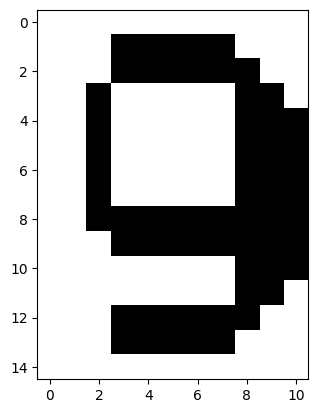

ValueError: could not convert string to float: ''

In [27]:
backlog_image = cv2.imread('iframe.png')

backlog_cards = image_parser.get_backlog(backlog_image)
backlog_cards

In [31]:
state = env._get_state()
print(state)

info = env.get_info()
print(info)

action = agent.get_action(state, info)
print(action)

[ 4.     0.33  25.     4.     2.73   2.     1.     2.     2.     0.
  1.     0.     0.     1.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     9.     9.     1.
  0.     0.035  2.     3.    10.    10.     1.     0.     0.035  2.
  3.     9.     9.     1.     0.     0.035  2.     3.    11.    11.
  1.     0.     0.035  2.     3.    11.    11.     1.     0.     0.035
  2.     3.    11.    11.     1.     0.     0.035  2.     3.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.   ]
{'actions': [0, 9, 10, 11, 12, 13, 14]}
13


Start decomposition


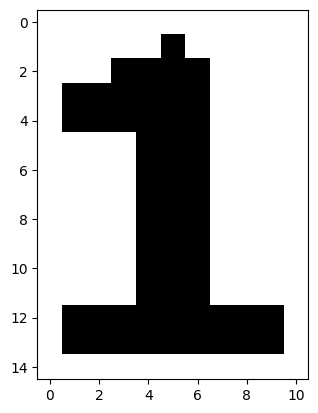

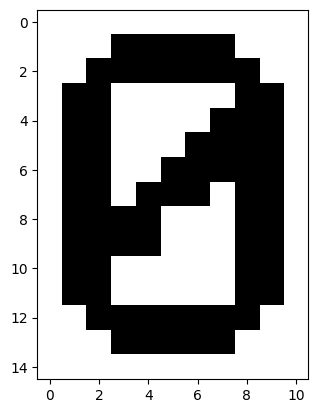

frozenset({(0, 115), (1, 188), (2, 30)})
9.0
11.0
8.0
10.0


In [30]:
time.sleep(5)
apply_web_action(action, driver, iframe, env)

In [13]:
iframe.rect

{'height': 540, 'width': 960, 'x': 29.600000381469727, 'y': 20}

In [16]:
driver.quit()